In [2]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 6.5 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os,glob
import numpy as np

# Data Visualization libs
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D,GlobalAveragePooling2D,Flatten,Dense,Dropout,MaxPool2D
from keras.callbacks import Callback,EarlyStopping
from keras.applications import Xception
from keras.applications.inception_v3 import preprocess_input
from sklearn.metrics import classification_report
from keras.optimizers import Adam
import tensorflow as tf

In [12]:
file_path='/content/drive/MyDrive/Images'
name_class=os.listdir(file_path)
name_class

['Fall', 'Normal']

In [14]:
file_path='/content/drive/MyDrive/Images'
file_paths = glob.glob(file_path + '/**/*.*', recursive=True)
labels = list(map(lambda x: os.path.split(os.path.split(os.path.split(x)[0])[0])[1], file_paths))
len(file_paths)

1860

In [15]:
filepath=pd.Series(file_paths,name='FilePath').astype(str)
labels=pd.Series(labels,name='Label')
data=pd.concat([filepath,labels],axis=1)
data=data.sample(frac=1).reset_index(drop=True)
data.sample(5)

,FilePath,Label
1237,/content/drive/MyDrive/Images/Fall/Single/fall...,Fall
1331,/content/drive/MyDrive/Images/Fall/Single/fall...,Fall
532,/content/drive/MyDrive/Images/Normal/Single/ad...,Normal
1612,/content/drive/MyDrive/Images/Fall/Single/fall...,Fall
1618,/content/drive/MyDrive/Images/Fall/Single/fall...,Fall


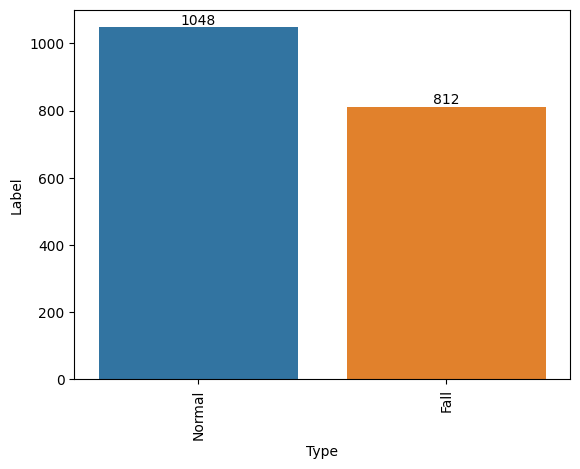

In [16]:
counts=data.Label.value_counts()
sns.barplot(x=counts.index,y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90)

# Annotate each bar with the exact count
for index, value in enumerate(counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

# Show the plot
plt.show()

In [17]:
train,test =train_test_split(data,test_size=0.25,random_state=42)

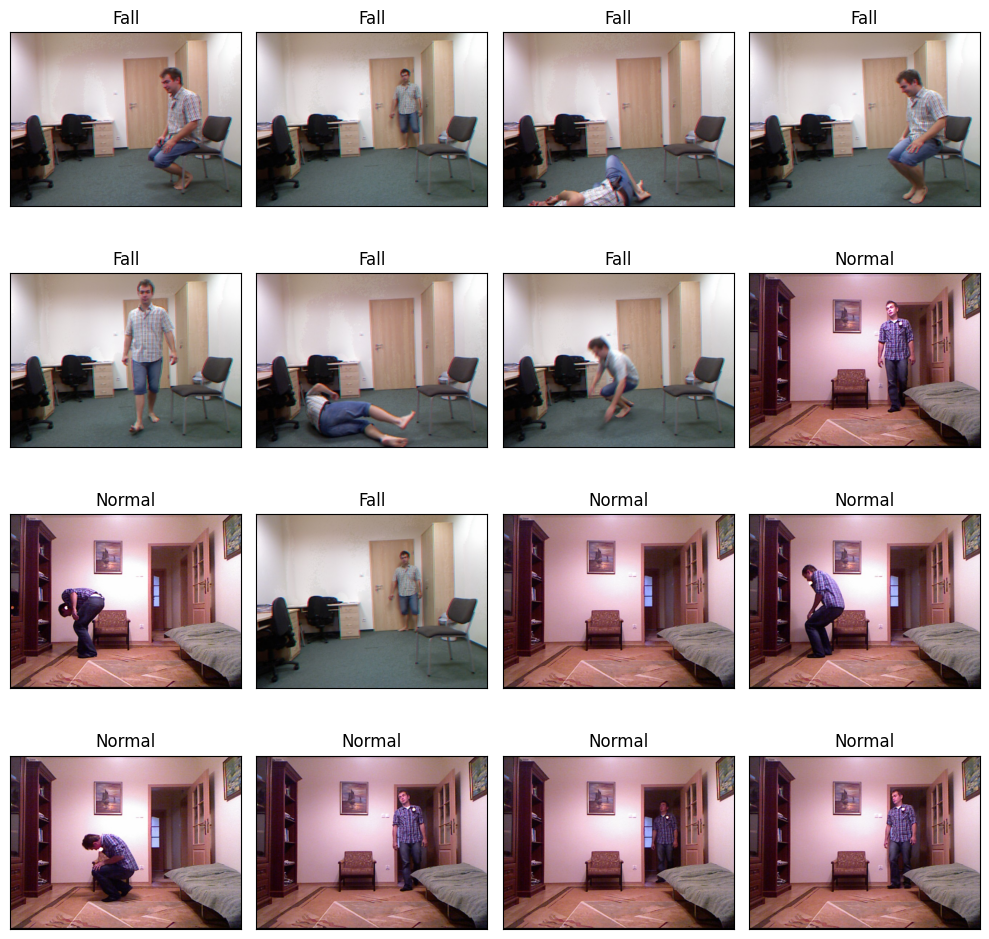

In [18]:
fig,axes=plt.subplots(nrows=4,ncols=4,figsize=(10,10),subplot_kw={'xticks':[],'yticks':[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.FilePath[i]))
    ax.set_title(data.Label[i])

plt.tight_layout()
plt.show()


In [19]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

In [20]:
train_gen=train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='FilePath',
    y_col='Label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    zoom_range = 0.2,
    seed=42
)

valid_gen=train_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='FilePath',
    y_col='Label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    zoom_range = 0.2,
    seed=42
)

test_gen=test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='FilePath',
    y_col='Label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    zoom_range = 0.2,
    shuffle=False
)

Found 1395 validated image filenames belonging to 2 classes.
Found 465 validated image filenames belonging to 2 classes.
Found 465 validated image filenames belonging to 2 classes.


In [21]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.3))

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))


model.add(Conv2D(32, 3, padding="same", activation="relu"))

model.add(Flatten())

model.add(Dense(128,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(64,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(32, activation = "sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 56, 56, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        7

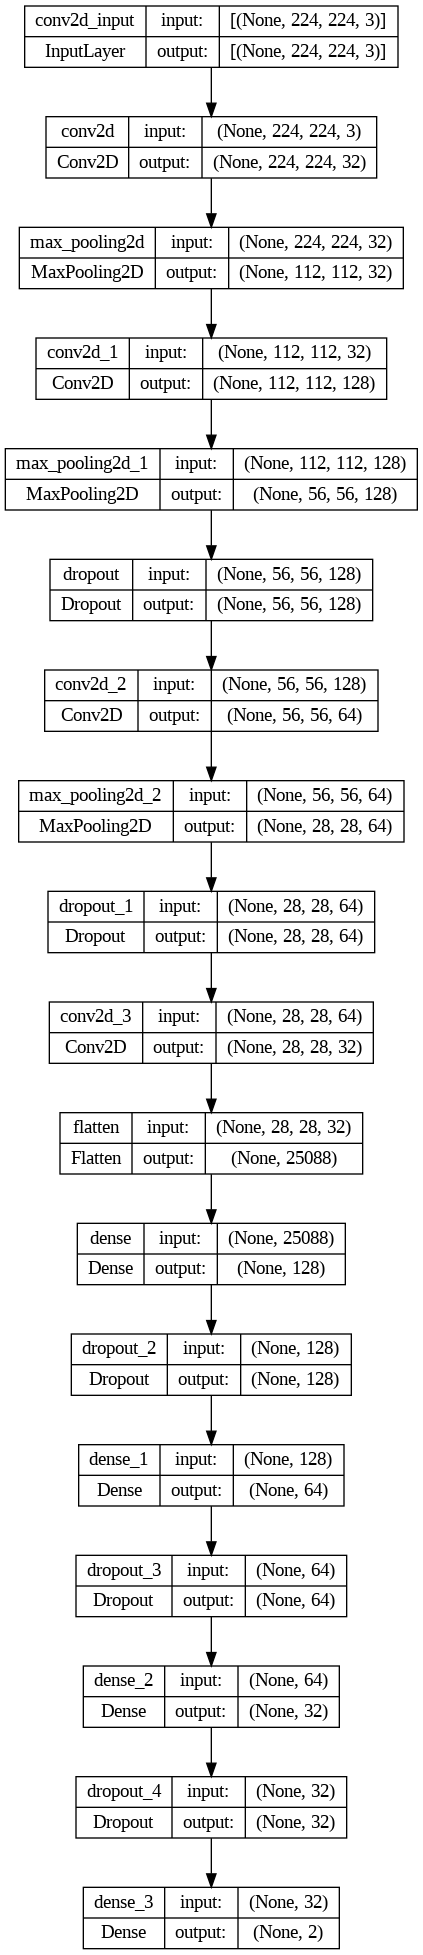

In [22]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

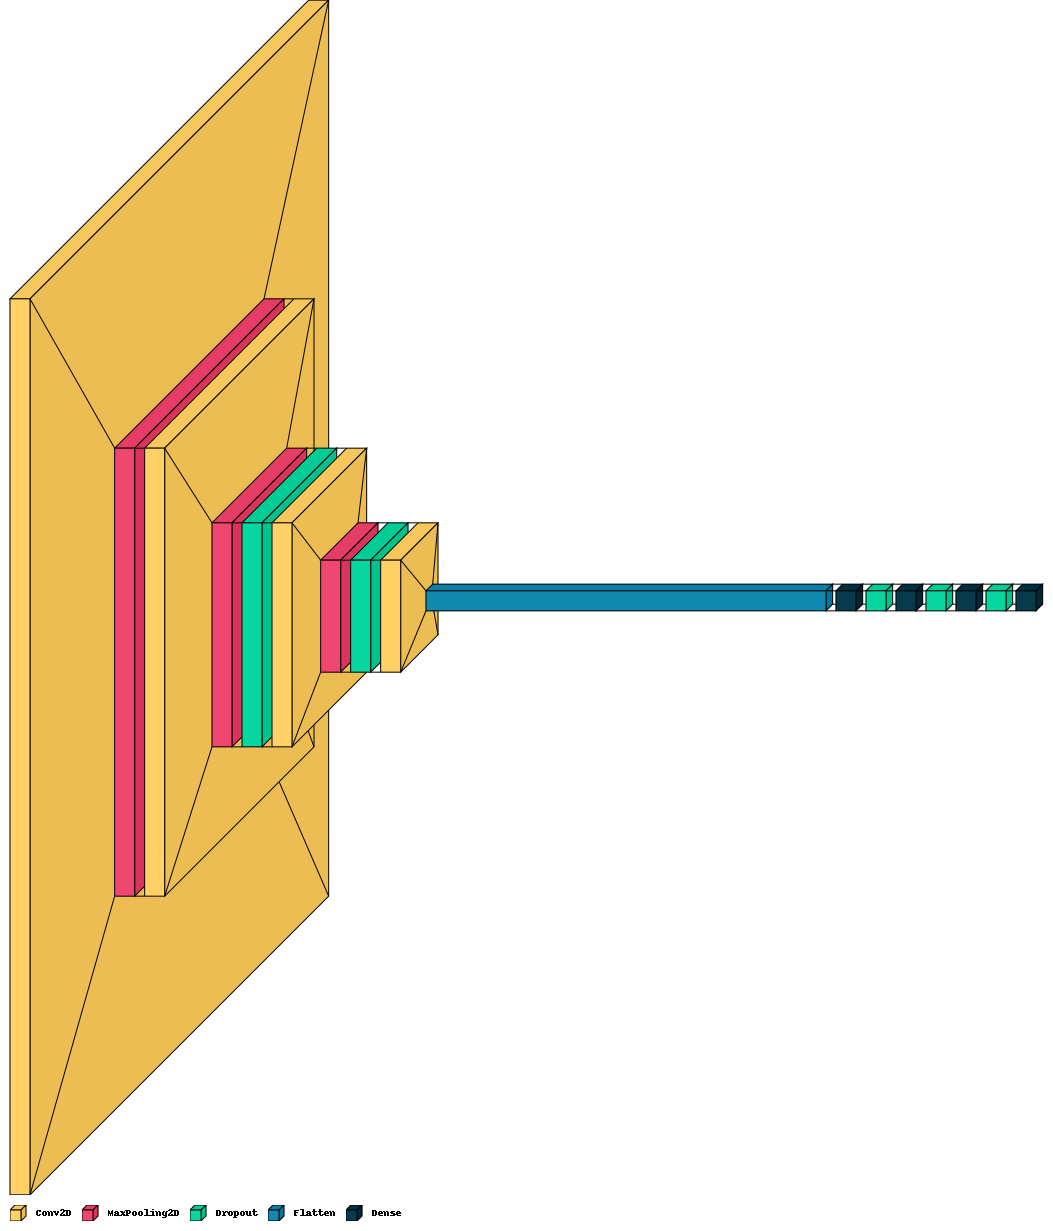

In [23]:
import visualkeras
visualkeras.layered_view(model, legend=True) # without custom font

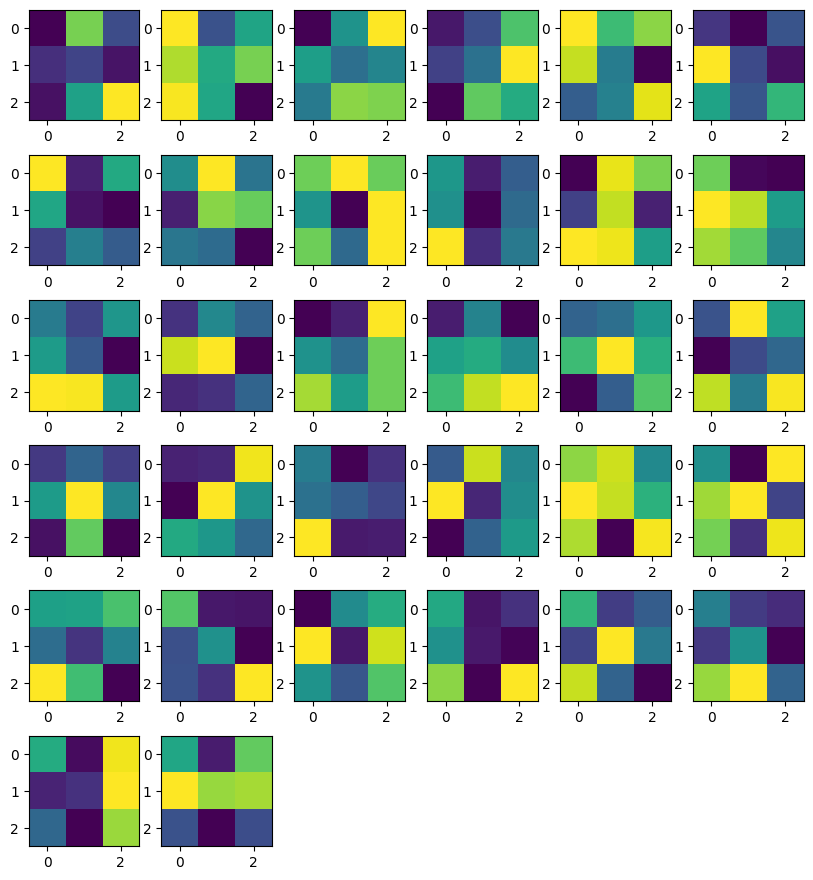

In [24]:
weights = model.get_layer('conv2d').get_weights()[0]
plt.figure(figsize=(10, 11))
for i in range(weights.shape[3]):
    plt.subplot(6, 6, i+1)
    plt.imshow(weights[:, :, 0, i], cmap='viridis')

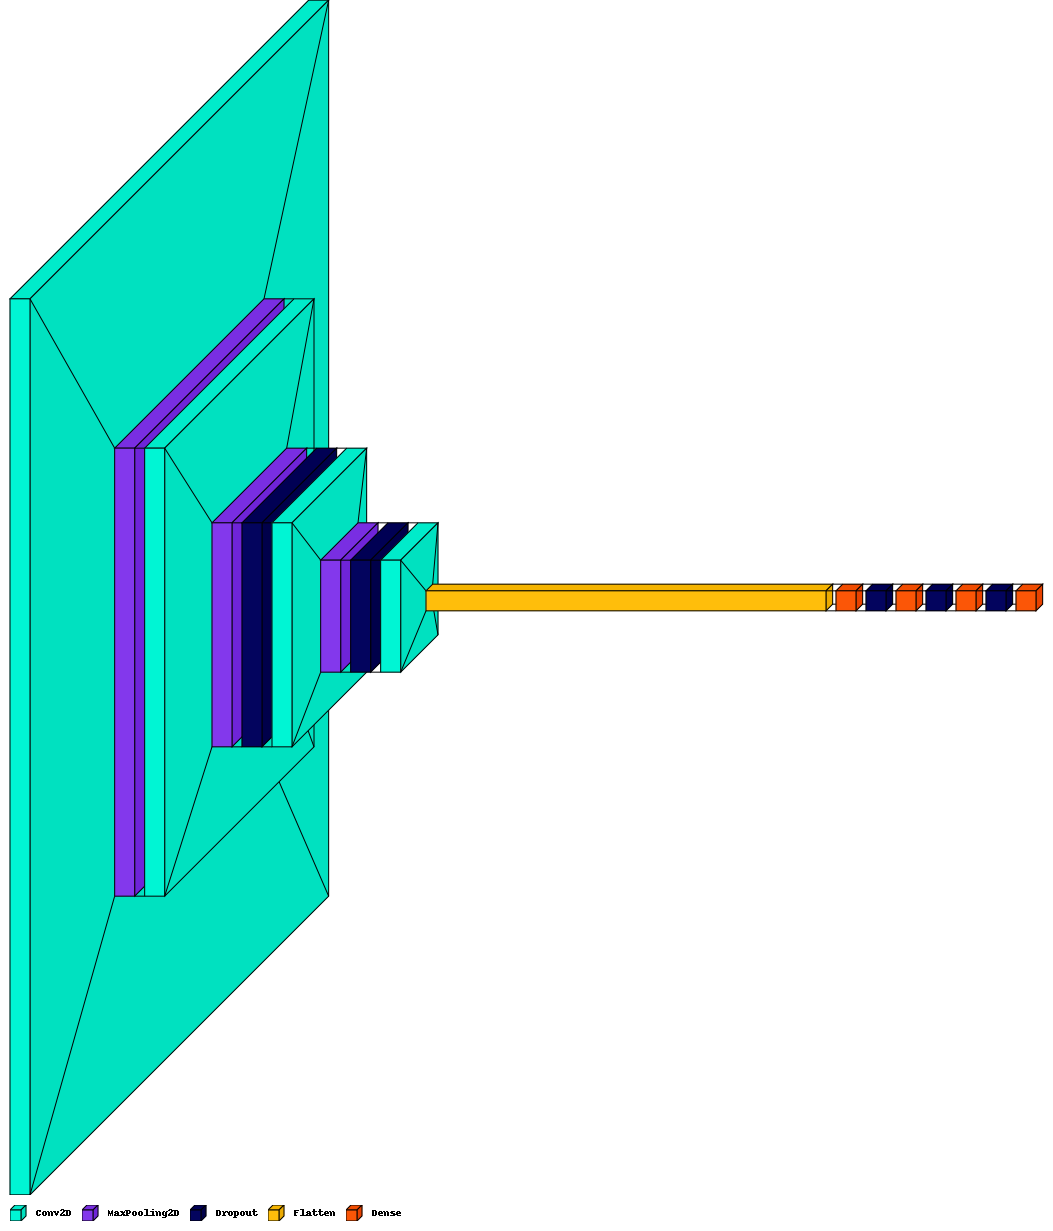

In [25]:
from tensorflow.keras import layers
from collections import defaultdict
color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = '#00f5d4'
color_map[layers.MaxPooling2D]['fill'] = '#8338ec'
color_map[layers.Dropout]['fill'] = '#03045e'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = '#ffbe0b'
visualkeras.layered_view(model, legend=True,color_map=color_map)

In [26]:
opt = Adam(learning_rate=0.01)
# model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
model_checkpoint = ModelCheckpoint(filepath = "./best_model.h5" ,
                     monitor = "accuracy", verbose = 1 ,
                     save_best_only = True  )
early_stopping = EarlyStopping(monitor = "accuracy",
                   min_delta= 0.01, patience = 5 ,
                   verbose = 1)
call_backs = [model_checkpoint, early_stopping]

In [28]:
# # history = model.fit(x_train,y_train,epochs = 50 , validation_data = (x_val, y_val))
history=model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=3
)
# history = model.fit_generator(train_gen, validation_data=valid_gen,
#                               steps_per_epoch= 10 , epochs= 30 , callbacks =call_backs)
# #epoch 25 - 96.7% acc , 19 96% acc are best , 28 - 96.77% acc

Epoch 1/3
44/44 [==============================] - 503s 11s/step - loss: 0.1339 - accuracy: 0.9606 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 2/3
44/44 [==============================] - 269s 6s/step - loss: 0.0258 - accuracy: 0.9993 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 3/3
44/44 [==============================] - 262s 6s/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.0037 - val_accuracy: 1.0000


In [29]:
model.save('/content/drive/MyDrive/human actions CNN/Custom_model_copy.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
h = history.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<ipython-input-31-a2afd7647894>:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(h['loss'], 'go--', c = "green")
<ipython-input-31-a2afd7647894>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(h['accuracy'], 'go--', c = "red")


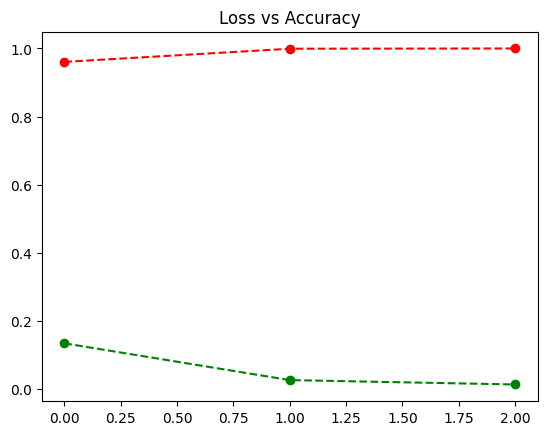

In [31]:
plt.plot(h['loss'], 'go--', c = "green")
plt.plot(h['accuracy'], 'go--', c = "red")

plt.title("Loss vs Accuracy")
plt.show()

In [32]:
results=model.evaluate(test_gen,verbose=0)

print('Test Loss: {:.5f}'.format(results[0]))
print('Test Accurracy: {:.2f}%'.format(results[1]*100))

Test Loss: 0.00374
Test Accurracy: 100.00%


In [33]:
pred=model.predict(test_gen)
pred=np.argmax(pred,axis=1)

labels=(train_gen.class_indices)
labels=dict((v,k) for k,v in labels.items())
pred=[labels[k] for k in pred]


# Print activations for specific layers/nodes
print(pred)

15/15 [==============================] - 24s 2s/step
['Fall', 'Fall', 'Normal', 'Fall', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Fall', 'Fall', 'Fall', 'Fall', 'Normal', 'Normal', 'Normal', 'Normal', 'Fall', 'Normal', 'Normal', 'Fall', 'Fall', 'Fall', 'Normal', 'Fall', 'Normal', 'Fall', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Fall', 'Fall', 'Normal', 'Fall', 'Normal', 'Fall', 'Normal', 'Normal', 'Fall', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Fall', 'Fall', 'Fall', 'Fall', 'Normal', 'Fall', 'Fall', 'Normal', 'Normal', 'Fall', 'Normal', 'Normal', 'Normal', 'Fall', 'Normal', 'Normal', 'Normal', 'Normal', 'Fall', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Fall', 'Normal', 'Normal', 'Fall', 'Fall', 'Normal', 'Normal', 'Normal', 'Fall', 'Normal', 'Fall', 'Fall', 'Fall', 'Normal', 'Fall', 'Normal', 'Fall', 'Normal', 'Normal', 'Fall', 'Normal', 'Normal', 'Normal', 'Normal', 

In [34]:
y_test=list(test.Label)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

        Fall       1.00      1.00      1.00       206
      Normal       1.00      1.00      1.00       259

    accuracy                           1.00       465
   macro avg       1.00      1.00      1.00       465
weighted avg       1.00      1.00      1.00       465



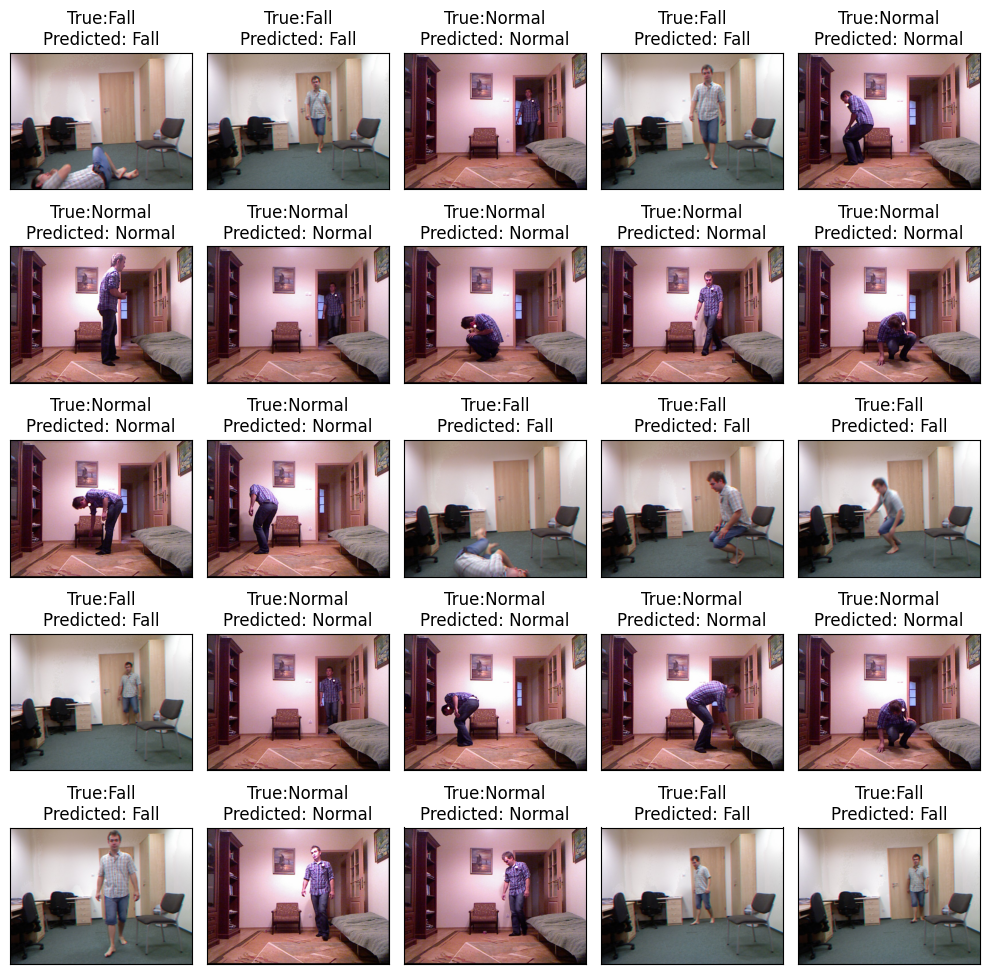

In [35]:
fig,axes=plt.subplots(nrows=5,ncols=5,figsize=(10,10),subplot_kw={'xticks':[],'yticks':[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.FilePath.iloc[i]))
    ax.set_title(f'True:{test.Label.iloc[i]}\nPredicted: {pred[i]}')

plt.tight_layout()
plt.show()

In [36]:
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    num_classes = len(class_names)
    plt.xticks(np.arange(num_classes), class_names, rotation=45)
    plt.yticks(np.arange(num_classes), class_names)

    plt.xlabel('Predicted')
    plt.ylabel('True')

    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', color='white' if i == j else 'black')

    plt.tight_layout()
    plt.show()

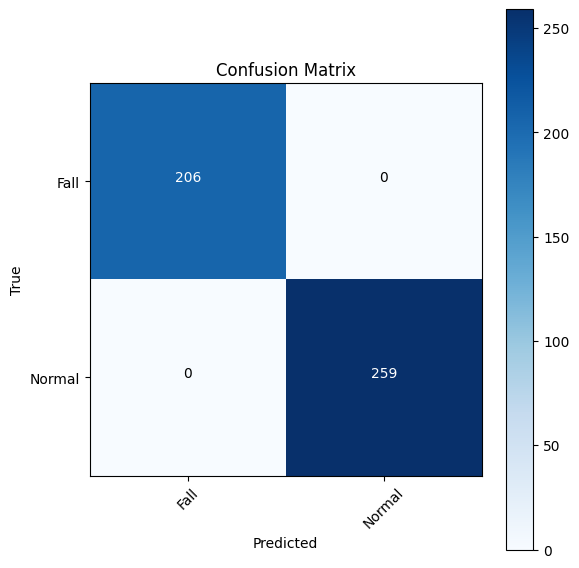

In [37]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, pred)
class_names = list(labels.values())
plot_confusion_matrix(conf_matrix, class_names)

In [38]:
import cv2
import numpy as np
from matplotlib.pyplot import imread,imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions,preprocess_input

In [43]:
from tensorflow.keras.models import load_model
# model = load_model('F:/Machine Learning/Assignments/Custom_model_copy.h5')
img_path='/content/drive/MyDrive/Images/Normal/Single/adl-01-cam0-rgb-046.png'
# F:/Machine Learning/Assignments/CNN/Unhealthy/Single/7374.jpg
img=cv2.imread(img_path)
img=cv2.resize(img,(224,224))

x=np.expand_dims(img,axis=0)
x=preprocess_input(x)
result=model.predict(x)

p=(result*100).astype('int')
pp=list(p[0])

index=pp.index(max(pp))
print(f' Human Action Detected: {class_names[index]}')

1/1 [==============================] - 0s 272ms/step
 Human Action Detected: Normal
